# 05 - QAOA circuit with advanced circuit parameterizations

Here we illustrate the use of the `Annealing` and `Fourier` parameter classes included in the OpenQAOA. Like always, we first start with importing relevant modules from OpenQAOA

In [1]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems.problem import MinimumVertexCover

#import the QAOA workflow model
from openqaoa.workflows.optimizer import QAOA

#import method to specify the device
from openqaoa.devices import create_device

## Create a problem instance
We begin by creating a problem instance for a simple MinimumVertexCover problem for a random graph created using the `random_instance` method of the class.

In [2]:
# Use the MinimumVertexCover class to instantiate the problem.
mvc_prob = MinimumVertexCover.random_instance(n_nodes=6, edge_probability=0.9, seed=3456)

# The method `get_qubo_problem()` translates the problem into a binary Qubo problem. 
# The binary values can be access via the `asdict()` method.
mvc_qubo = mvc_prob.get_qubo_problem()

#### Extract the exact solution for a small enough problem



In [3]:
hamiltonian = mvc_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: 5.0, Solution: ['111110', '111101', '111011', '110111', '101111', '011111']


<a id='annealing'></a>

## The Annealing parameter class

In quantum annealing, we start in the ground state of a _mixer_ (or _reference_) Hamiltonian $H_M$, and gradually transform to the ground state of a _cost_ Hamiltonian $H_C$, according to some annealing schedule function $s(t)$, where $t$ denotes time. If it were possible to perform the transformation infinitesimally slowly, we would be guaranteed to arrive at the exact ground state of the cost Hamiltonian. In practice, the transformation is performed over some finite time, and we hope to prepare the ground state of $H_C$ with some acceptably high probability.

At any time $t$ during the procedure, the instantaneous Hamiltonian is given by

$$H(t) = \left(1 - s(t)\right)H_M + s(t)H_C$$

where $s(0) = 0$, and $s(t = T) = 1$, and $T$ is the total annealing time. We see that the strengths with which $H_M$ and $H_C$ act at a given time are related: the mixer is applied with a weight $(1 - s(t))$, and the cost Hamiltonian with weight $s(t)$. It is common to view the QAOA as a form of discretised annealing, where the procedure is performed in a fixed number of steps $p$. However, the coefficients of the mixer and cost Hamiltonians need not be related in the simple way that they are in a conventional annealing schedule. 

The `AnnealingParams` parameter class illustrates what is perhaps the first conceptual step from annealing, towards the more conventionally used parametrisations of QAOA. Using `AnnealingParams`, we prepare an output quantum state with a circuit described by the unitary operator

$$U = \mathcal{T}\left(\Pi_{j=1}^p \exp\left[-i(1-s(t_j)) H_M \Delta t\right]\exp\left[-i s(t_j) H_C \Delta t\right]\right),$$

where the object $\mathcal{T}$ tells us to correctly order the terms, increasing from $j=1$ to $j=p$ from right to left in the product.

Here, we have a fixed temporal step of size $\Delta t$, and we need to specify what the values of the annealing schedule function should be at the different timesteps. That is, we need to provide a list of the values of $s(t_j$) for $j = 1,..,p$.

Here we illustrate the use of the `AnnealingParams` class, whose value we envisage primarily as a didactic or research tool. Specifically, let's compare the annealing parametrisation with the `StandardParams` parametrisation.

First, we set up the Hamiltonian as usual.

### Initialize QAOA model with Annealing parameterization

In [4]:
q_annealing = QAOA()
p=6
q_annealing.set_circuit_properties(p=p, param_type='annealing', init_type='ramp')
q_annealing.set_classical_optimizer(maxiter=200)
q_annealing.compile(mvc_qubo)

In [5]:
# run optimization
q_annealing.optimize()
print("Optimized cost with AnnealingParams:", q_annealing.results.optimized['optimized cost'])

Optimized cost with AnnealingParams: 8.306711989816982


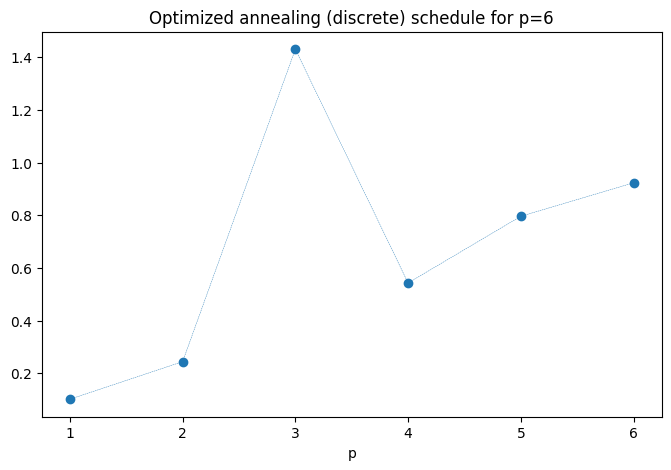

In [6]:
# annealing optimized schedule
opt_schedule = q_annealing.results.optimized['optimized angles']
p_i = range(1,p+1)
fig = plt.figure(figsize=(8,5))
plt.plot(p_i,opt_schedule,lw=0.3,ls='--',marker='o')
plt.xlabel('p')
plt.title(f'Optimized annealing (discrete) schedule for p={p}');

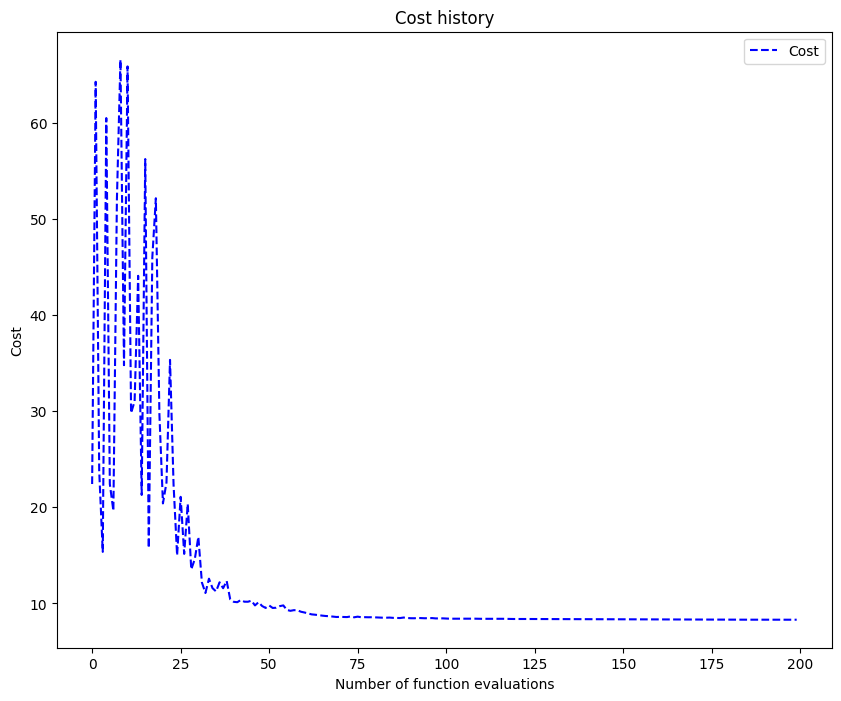

In [7]:
q_annealing.results.plot_cost()

#### Comparison with Standard parameterization

In [8]:
q_std = QAOA()
p=6
q_std.set_circuit_properties(p=p, param_type='standard', init_type='ramp')
q_std.set_classical_optimizer(maxiter=200)
q_std.compile(mvc_qubo)

In [9]:
# run optimization
q_std.optimize()
print("Optimized cost with StandardParams:", q_std.results.optimized['optimized cost'])

Optimized cost with StandardParams: 6.9918999988276465


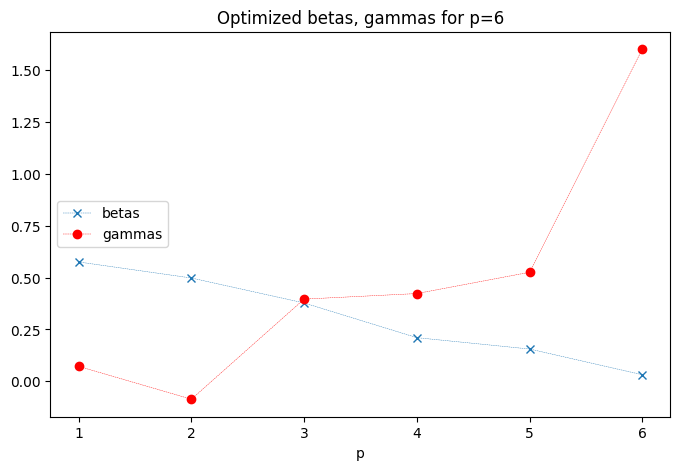

In [10]:
# annealing optimized schedule
opt_angles = q_std.results.optimized['optimized angles']
opt_betas = opt_angles[:p]
opt_gammas = opt_angles[p:]
fig = plt.figure(figsize=(8,5))
plt.plot(p_i,opt_betas,lw=0.3,ls='--',marker='x',label='betas')
plt.plot(p_i,opt_gammas,lw=0.3,ls='--',marker='o',label='gammas',color='red')
plt.xlabel('p')
plt.legend(loc='center left')
plt.title(f'Optimized betas, gammas for p={p}');

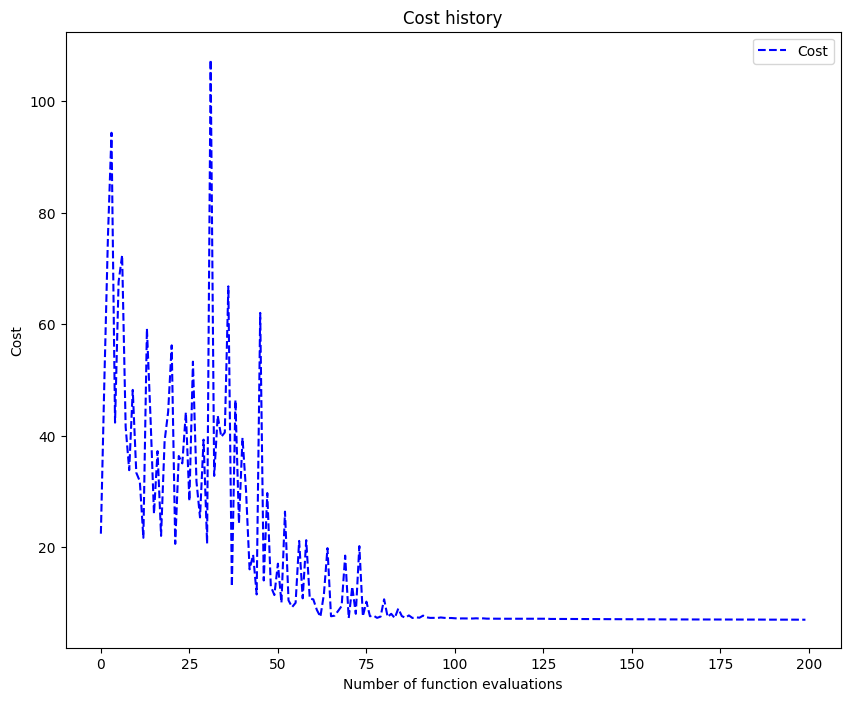

In [11]:
q_std.results.plot_cost()

Observe that, at least for this simple problem, the expectation values obtained are reasonably similar, yet we use half the number of parameters in `AnnealingParams` as `StandardParams`.

In the optimal `StandardParams`, we see a general downward (upward) trend in the betas (gammas), which is consistent with the annealing picture that the mixer Hamiltonian is gradually turned off, and the cost Hamiltonian is gradually turned on. 

Following [Ref 1](#references), we can attempt to make a connection between the two pictures, by interpreting the sum of all the `betas` and `gammas` as a total annealing time. We can then define the corresponding annealing schedule function value at each time as

$$s(t_i) = \frac{|\gamma_i|}{|\beta_i| + |\gamma_i|}$$

When we plot this function, we see a similar behaviour to that of the optimal annealing schedule we found above.

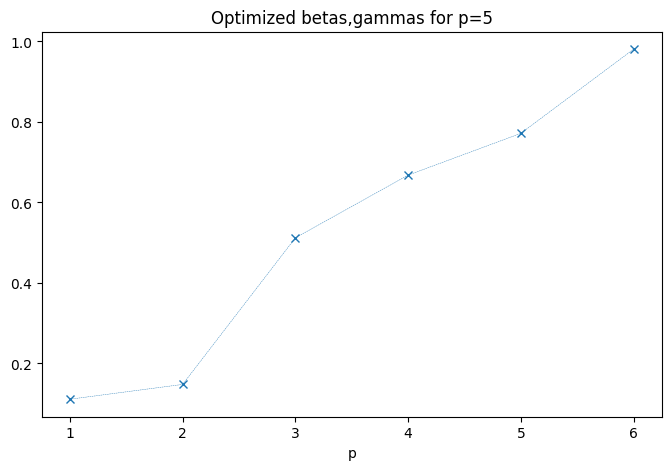

In [12]:
hybrid_params = [np.abs(opt_gammas[i])/(np.abs(opt_gammas[i]) + np.abs(opt_betas[i])) for i in range(p)]

fig = plt.figure(figsize=(8,5))
plt.plot(p_i,hybrid_params,lw=0.3,ls='--',marker='x',label='betas')
plt.xlabel('p')
plt.title('Optimized betas,gammas for p=5');

<a id='fourier'></a>

## The Fourier parameter class

This parameter class originated from attempts to find heuristic ways of reducing the number of parameters required to perform QAOA. Based on empirical observations in patterns of the optimal QAOA angles, Zhuo et al (see [Ref 1](#references)) proposed considering the discrete Fourier transforms of `betas` and `gammas` as an alternative, more economical parametrisation.

The basic idea kicks off from  the conventional QAOA parametrisation, i.e. what we call the `StandardParams` class. Here, at each iteration in QAOA we have one angle for all of the mixer Hamiltonian terms, and one angle for all of the cost Hamiltonian terms. That is, the `StandardParams` parametrisation requires the specification of $2p$ numbers, a `beta` and a `gamma` for each timestep.

In the Fourier representation, we switch instead to a set of $2q$ parameters, denoted $\vec{v}$ and $\vec{u}$, which are related to $\vec{\beta}$ and $\vec{\gamma}$ by


$$\beta_i^{(p)} = \sum_{k=0}^{q-1} v_k \cos\left[(2k+1)i\frac{\pi}{2p}\right]$$
$$\gamma_i^{(p)} = \sum_{k=0}^{q-1} u_k \sin\left[(k+1/2)(i+1)\frac{\pi}{p}\right]$$

where $i = 1,...,p$. The insight of Zhou et al is that the optimal parameters found are often empirically seen to be smoothly varying functions for certain problems (such as the one in the section above on annealing), and that it should then be possible to use a reduced parameter set consisting of only the lowest $q$ frequency components of those functions. Clearly, for $q\geq p$ we have the full expressivity of the original parameter set (i.e. the $\beta$s and $\gamma$s). In this parametrisation, for fixed $q$, the optimisation problem therefore becomes that of finding the optimal Fourier components $v_k$ and $u_k$. 

In [Ref 1](#references), the authors show that certain variants of this basic Fourier parametrisation can perform significantly better than a  randomised brute force search through parameter space, for MaxCut problems on 3-regular and 4-regular graphs. For the purpose of this notebook, we will compare `FourierParams` and `StandardParams` for different random instances of a MinimumVertexCover problems.

We will random graphs on 6 nodes, and use the `ramp`(short for `linear_ramp_from_hamiltonian`) initialization strategy to generate initial parameters for each of the two parameterizations. We generate a random problem instance, and find the optimal ground state energy returned using the two parametrisations. We then compute the relative error of each from the true ground state energy. 

First we define a convenience function for the following computations:

### Initialize QAOA model with Fourier parameterizations

In [13]:
def compare_fourier_std_optimize(n_nodes, edge_probability, p_fourier, q, p_std):
    """
    Produce a random graph on the specified number of nodes, with edge_probability.
    Run the MinimumVertexCover problem on this graph and compare the optimization performance
    between the StandardParams and FourierParams
    
    Parameters
    ----------
    n_nodes: `int`
        The number of nodes in the graph
    edge_probability: `float`
        An edge_probability between nodes. Between 0 and 1.
    p_fourier: `int`
        Depth of QAOA circuit for Fourier parameterized circuits
    q: `int`
        Depth of fourier parameters of optimization
    p_std: `int`
        Depth of QAOA circuit for Standard parameterized circuits
     
    Return
    ------
    (minimized_cost_fourier, minimized_cost_std, exact_cost): `tuple`
    The optimal cost function values obtained by each method, as well as its exact minimum value 
    (found by diagonalising the Hamiltonian).
    """
    mvc_random = MinimumVertexCover.random_instance(n_nodes=n_nodes,edge_probability=edge_probability)
    mvc_random_qubo = mvc_random.get_qubo_problem()
    
    q_std = QAOA()
    q_std.set_circuit_properties(p=p_std, param_type='standard', init_type='ramp', linear_ramp_time=0.7)
    q_std.set_classical_optimizer(maxiter=500)
    q_std.compile(mvc_qubo,verbose=False)
    q_std.optimize();
    
    q_fourier = QAOA()
    q_fourier.set_circuit_properties(p=p_fourier, param_type='fourier', init_type='ramp',q=q, linear_ramp_time=0.7)
    q_fourier.set_classical_optimizer(maxiter=500)
    q_fourier.compile(mvc_qubo,verbose=False)
    q_fourier.optimize();
    
    minimized_cost_std = q_std.results.optimized['optimized cost']
    minimized_cost_fourier = q_fourier.results.optimized['optimized cost']
    exact_cost = ground_state_hamiltonian(mvc_random_qubo.hamiltonian)[0]
    
    return (minimized_cost_fourier, minimized_cost_std, exact_cost)

To begin to appreciate the benefits of the Fourier parametrisation, let's compare the case $p=2$ using `StandardParams` with the case $q = 2, p=3$ using `FourierParams`. Here, we are optimising over the same total number of parameters, however the `FourierParams` ought to be capturing features of a more expressive circuit. 

In [14]:
p_fourier = 3
p_std = 2
q = 2

samples = 10

err_fourier = np.zeros(samples)
err_std = np.zeros(samples)

for i in range(samples):
    
    res_fourier, res_std, ground_energy = compare_fourier_std_optimize(6, 0.6, p_fourier, q, p_std);

    # Compute relative error 
    err_fourier[i] = np.absolute((res_fourier - ground_energy)/ground_energy)
    err_std[i] = np.absolute((res_std - ground_energy)/ground_energy)
    
print("Mean error using FourierParams: ", np.mean(err_fourier))
print("Mean error using StandardParams: ", np.mean(err_std))

Mean error using FourierParams:  1.0213868219769464
Mean error using StandardParams:  2.755059635685694


We see that the Fourier parametrisation returns a more accurate cost function value. Let's go one step further and try the case $p=1$ with `StandardParams`, and $q = 1, p=3$ with `FourierParams`.

In [15]:
p_fourier = 3
p_std = 1
q = 1

samples = 10

err_fourier = np.zeros(samples)
err_std = np.zeros(samples)

for i in range(samples):
    
    res_fourier, res_std, ground_energy = compare_fourier_std_optimize(6, 0.6, p_fourier, q, p_std);

    # Compute relative error 
    err_fourier[i] = np.absolute((res_fourier - ground_energy)/ground_energy)
    err_std[i] = np.absolute((res_std - ground_energy)/ground_energy)
    
print("Mean error using FourierParams: ", np.mean(err_fourier))
print("Mean error using StandardParams: ", np.mean(err_std))

Mean error using FourierParams:  1.063249785004469
Mean error using StandardParams:  8.238259932656561


In this case, we find an even greater separation in accuracy between the two methods, as intuitively expected. 

While we have studied only small and relatively simple problems in the above examples, the results suggest that the economy of the `Fourier` parametrisation may be worth further investigation.

In [16]:
p_fourier = 3
p_std = 1
q = 1

q_std = QAOA()
q_std.set_circuit_properties(p=p_std, param_type='standard', init_type='ramp')
q_std.set_classical_optimizer(maxiter=500)
q_std.compile(mvc_qubo,verbose=False)
q_std.optimize();

q_fourier = QAOA()
q_fourier.set_circuit_properties(p=p_fourier, param_type='fourier', init_type='ramp', q=q)
q_fourier.set_classical_optimizer(maxiter=500)
q_fourier.compile(mvc_qubo,verbose=False)
q_fourier.optimize();

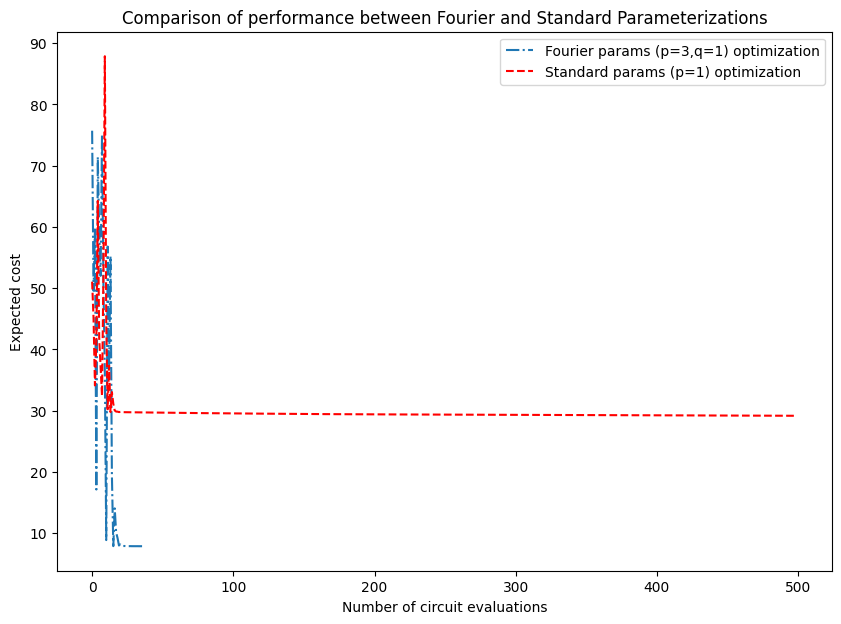

In [17]:
fig = plt.figure(figsize=(10,7))
plt.plot(q_fourier.results.intermediate['intermediate cost'],label='Fourier params (p=3,q=1) optimization',ls='-.')
plt.plot(q_std.results.intermediate['intermediate cost'],label='Standard params (p=1) optimization',ls='--',color='red')
plt.xlabel('Number of circuit evaluations')
plt.ylabel('Expected cost')
plt.legend();
plt.title('Comparison of performance between Fourier and Standard Parameterizations');

## References

1. L. Zhou et al, __[*Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices*](https://arxiv.org/abs/1812.01041)__